In [ ]:
###### ARTI308 - Machine Learning

# Lab 4: Data Quality Assessment & Preprocessing

In real-world machine learning projects, data is often:
- Incomplete (missing values)
- Noisy (outliers or random errors)
- Inconsistent (wrong formats, mixed units)

Before building any machine learning model, we must clean and prepare the data properly.

![step2.png](step2.png)

In this lab, we will apply practical preprocessing techniques step by step.

In [18]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

## 1. Load Dataset

In [19]:
pd.set_option("display.max_columns", None)

df = pd.read_csv("Chocolate_Sales.csv")
df.head(10)

,Sales Person,Country,Product,Date,Amount,Boxes Shipped
0,Jehu Rudeforth,UK,Mint Chip Choco,04/01/2022,"$5,320.00",180
1,Van Tuxwell,India,85% Dark Bars,01/08/2022,"$7,896.00",94
2,Gigi Bohling,India,Peanut Butter Cubes,07/07/2022,"$4,501.00",91
3,Jan Morforth,Australia,Peanut Butter Cubes,27/04/2022,"$12,726.00",342
4,Jehu Rudeforth,UK,Peanut Butter Cubes,24/02/2022,"$13,685.00",184
5,Van Tuxwell,India,Smooth Sliky Salty,06/06/2022,"$5,376.00",38
6,Oby Sorrel,UK,99% Dark & Pure,25/01/2022,"$13,685.00",176
7,Gunar Cockshoot,Australia,After Nines,24/03/2022,"$3,080.00",73
8,Jehu Rudeforth,New Zealand,50% Dark Bites,20/04/2022,"$3,990.00",59
9,Brien Boise,Australia,99% Dark & Pure,04/07/2022,"$2,835.00",102


## 2. Data Quality Assessment
### 2.1 Check Data Types
Data types must match the real meaning of each column.
For example:
- `Date` should be datetime
- `Revenue` should be numeric

In [20]:
df.dtypes

Sales Person     object
Country          object
Product          object
Date             object
Amount           object
Boxes Shipped     int64
dtype: object

df.info()

The dataset was inspected using info(), describe(), and isnull().
The Date and Amount columns were initially stored as object.
They were converted to the correct data types (datetime and numeric).

### 2.2 Convert Incorrect Data Types
We will convert:
- `Date` to datetime format
- `Amount` to numeric after removing currency symbols

In [21]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df['Amount'] = df['Amount'].replace(r'[\$,]', '', regex=True)
df['Amount'] = pd.to_numeric(df['Amount'])

df.dtypes

Sales Person             object
Country                  object
Product                  object
Date             datetime64[ns]
Amount                  float64
Boxes Shipped             int64
dtype: object

Now `Date` is correctly stored as *datetime64*.
`Amount` is now numeric *(float64)*.
This allows us to perform time-based grouping and numerical calculations correctly.

## 3. Handling Missing Values
### 3.1 Detect Missing Values
Missing values reduce data quality and can affect model performance.

In [22]:
df.isna().sum()

Sales Person     0
Country          0
Product          0
Date             0
Amount           0
Boxes Shipped    0
dtype: int64

The output shows whether any column contains missing values.
If all values are zero, the dataset is complete.
If any column contains missing values, we must handle them.

### 3.2 Demonstration: Introduce Artificial Missing Values
### Why?

Since our dataset has no missing values, we introduce artificial ones *for learning purposes*.

we will be running this line:

`df_missing.loc[0:5, 'Amount'] = np.nan`


- `df_missing`: The pandas DataFrame you are modifying.

- `.loc[0:5, 'Amount']`: This uses the label-based indexer to select specific rows and columns.

- `0:5`: Selects rows with index labels 0, 1, 2, 3, 4, and 5. In label-based indexing, the end index is inclusive.

- `'Amount'`: Selects the column named 'Amount'.

- `= np.nan`: Assigns the value np.nan (which stands for "Not a Number") to all the selected cells. This is the standard way to represent missing or null values in numerical columns in pandas. The column's data type will be converted to float

In [23]:
df_missing = df.copy()
df_missing.loc[0:5, 'Amount'] = np.nan
df_missing.isna().sum()

Sales Person     0
Country          0
Product          0
Date             0
Amount           6
Boxes Shipped    0
dtype: int64

Now the Amount column contains missing values.

In [24]:
print("Original shape: ",df.shape)
print("After removing some values: ",df_missing.shape)

Original shape:  (3282, 6)
After removing some values:  (3282, 6)


In [25]:
df_missing.head(10)

,Sales Person,Country,Product,Date,Amount,Boxes Shipped
0,Jehu Rudeforth,UK,Mint Chip Choco,2022-01-04,NaN,180
1,Van Tuxwell,India,85% Dark Bars,2022-08-01,NaN,94
2,Gigi Bohling,India,Peanut Butter Cubes,2022-07-07,NaN,91
3,Jan Morforth,Australia,Peanut Butter Cubes,2022-04-27,NaN,342
4,Jehu Rudeforth,UK,Peanut Butter Cubes,2022-02-24,NaN,184
5,Van Tuxwell,India,Smooth Sliky Salty,2022-06-06,NaN,38
6,Oby Sorrel,UK,99% Dark & Pure,2022-01-25,13685.0,176
7,Gunar Cockshoot,Australia,After Nines,2022-03-24,3080.0,73
8,Jehu Rudeforth,New Zealand,50% Dark Bites,2022-04-20,3990.0,59
9,Brien Boise,Australia,99% Dark & Pure,2022-07-04,2835.0,102


### Strategy 1: Remove Records
This strategy removes records containing missing data.
It works well if the number of missing rows is small.

In [26]:
df_removed = df_missing.dropna()
df_removed.shape

(3276, 6)

Artificial missing values were introduced in the Amount column.
The missing values were handled using dropna().
Rows containing missing values were removed.

In [27]:
df_removed.isna().sum()

Sales Person     0
Country          0
Product          0
Date             0
Amount           0
Boxes Shipped    0
dtype: int64

The dataset now has fewer rows.
If only a small portion of data was missing, this method is acceptable.

However, removing too many rows can reduce model performance.

### Strategy 2: Mean Imputation

![Mean.png](Mean.png)

The mean represents the average value.
It is commonly used for normally distributed data.

In [28]:
df_missing.head(10)

,Sales Person,Country,Product,Date,Amount,Boxes Shipped
0,Jehu Rudeforth,UK,Mint Chip Choco,2022-01-04,NaN,180
1,Van Tuxwell,India,85% Dark Bars,2022-08-01,NaN,94
2,Gigi Bohling,India,Peanut Butter Cubes,2022-07-07,NaN,91
3,Jan Morforth,Australia,Peanut Butter Cubes,2022-04-27,NaN,342
4,Jehu Rudeforth,UK,Peanut Butter Cubes,2022-02-24,NaN,184
5,Van Tuxwell,India,Smooth Sliky Salty,2022-06-06,NaN,38
6,Oby Sorrel,UK,99% Dark & Pure,2022-01-25,13685.0,176
7,Gunar Cockshoot,Australia,After Nines,2022-03-24,3080.0,73
8,Jehu Rudeforth,New Zealand,50% Dark Bites,2022-04-20,3990.0,59
9,Brien Boise,Australia,99% Dark & Pure,2022-07-04,2835.0,102


In [29]:
df_imputed_mean.head(10)

,Sales Person,Country,Product,Date,Amount,Boxes Shipped
0,Jehu Rudeforth,UK,Mint Chip Choco,2022-01-04,6026.272241,180
1,Van Tuxwell,India,85% Dark Bars,2022-08-01,6026.272241,94
2,Gigi Bohling,India,Peanut Butter Cubes,2022-07-07,6026.272241,91
3,Jan Morforth,Australia,Peanut Butter Cubes,2022-04-27,6026.272241,342
4,Jehu Rudeforth,UK,Peanut Butter Cubes,2022-02-24,6026.272241,184
5,Van Tuxwell,India,Smooth Sliky Salty,2022-06-06,6026.272241,38
6,Oby Sorrel,UK,99% Dark & Pure,2022-01-25,13685.000000,176
7,Gunar Cockshoot,Australia,After Nines,2022-03-24,3080.000000,73
8,Jehu Rudeforth,New Zealand,50% Dark Bites,2022-04-20,3990.000000,59
9,Brien Boise,Australia,99% Dark & Pure,2022-07-04,2835.000000,102


Missing values are now replaced with the column mean. 
This preserves dataset size but may reduce variability.
Mean imputation is sensitive to outliers.

Missing values are now replaced with the average revenue.
This preserves dataset size but may reduce variability.
Mean imputation is sensitive to outliers.

### Strategy 3: Median Imputation

![median_formula_2.png](median_formula_2.png)
The median is more robust to outliers than the mean.
It is preferred for skewed data.

In [31]:
df_imputed_median = df_missing.copy()
df_imputed_median['Amount'].fillna(df_imputed_median['Amount'].median(), inplace=True)

df_imputed_median.isna().sum()

C:\Users\evacn\AppData\Local\Temp\ipykernel_24796\491271210.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_imputed_median['Amount'].fillna(df_imputed_median['Amount'].median(), inplace=True)


Sales Person     0
Country          0
Product          0
Date             0
Amount           0
Boxes Shipped    0
dtype: int64

Missing values were handled using median imputation.
NaN values in the Amount column were replaced with the column median.
After imputation, no missing values remained.
Median imputation is more robust to outliers than mean imputation.

In [32]:
df_imputed_median.head(10)

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.

,Sales Person,Country,Product,Date,Amount,Boxes Shipped
0,Jehu Rudeforth,UK,Mint Chip Choco,2022-01-04,5220.745,180
1,Van Tuxwell,India,85% Dark Bars,2022-08-01,5220.745,94
2,Gigi Bohling,India,Peanut Butter Cubes,2022-07-07,5220.745,91
3,Jan Morforth,Australia,Peanut Butter Cubes,2022-04-27,5220.745,342
4,Jehu Rudeforth,UK,Peanut Butter Cubes,2022-02-24,5220.745,184
5,Van Tuxwell,India,Smooth Sliky Salty,2022-06-06,5220.745,38
6,Oby Sorrel,UK,99% Dark & Pure,2022-01-25,13685.000,176
7,Gunar Cockshoot,Australia,After Nines,2022-03-24,3080.000,73
8,Jehu Rudeforth,New Zealand,50% Dark Bites,2022-04-20,3990.000,59
9,Brien Boise,Australia,99% Dark & Pure,2022-07-04,2835.000,102


Missing values are replaced with the middle value.
This approach is safer when data contains extreme values.

## 4. Handling Outliers
Outliers are extreme values that can distort models.
We will detect outliers using IQR method.

![IQR.png](IQR.png)

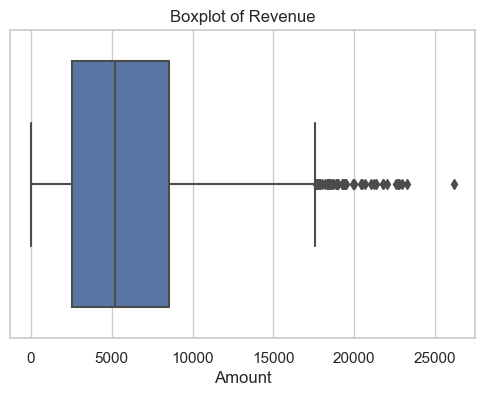

In [13]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df['Amount'])
plt.title("Boxplot of Revenue")
plt.show()

Points outside the whiskers represent potential outliers.
These extreme revenue values may influence model predictions.

### Detect Outliers using IQR
**Method: Interquartile Range (IQR)**

The IQR method defines outliers as values outside:

`Q1 - 1.5×IQR`  and  `Q3 + 1.5×IQR`

In [33]:
Q1 = df['Amount'].quantile(0.25)
Q3 = df['Amount'].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

outliers = df[(df['Amount'] < lower) | (df['Amount'] > upper)]
outliers.head(15)

,Sales Person,Country,Product,Date,Amount,Boxes Shipped
66,Van Tuxwell,Australia,Organic Choco Syrup,2022-08-10,19453.00,14
135,Van Tuxwell,India,Organic Choco Syrup,2022-05-16,19929.00,174
212,Marney O'Breen,UK,Smooth Sliky Salty,2022-05-13,18991.00,88
434,Jan Morforth,New Zealand,Mint Chip Choco,2022-06-30,18340.00,285
543,Ches Bonnell,India,Peanut Butter Cubes,2022-01-27,22050.00,208
589,Curtice Advani,India,Smooth Sliky Salty,2022-04-19,19327.00,135
609,Jan Morforth,Australia,Mint Chip Choco,2022-02-22,17626.00,103
751,Rafaelita Blaksland,New Zealand,Eclairs,2022-02-07,19481.00,51
806,Brien Boise,India,85% Dark Bars,2022-08-09,18032.00,205
1008,Kaine Padly,UK,After Nines,2022-01-21,18697.00,176


The output displays records considered extreme based on statistical boundaries.
These may be valid high-value transactions or potential data errors.

Outliers were detected using the IQR method.
Values below the lower bound or above the upper bound were identified as outliers.
These extreme values may negatively affect model performance.

### Remove Outliers
We remove values outside the acceptable range.

In [34]:
df_no_outliers = df[(df['Amount'] >= lower) & (df['Amount'] <= upper)]
print("Original shape: ",df.shape)
print("After removing outliers: ",df_no_outliers.shape)

Original shape:  (3282, 6)
After removing outliers:  (3232, 6)


Outliers were removed using IQR boundaries.
The dataset size decreased after removing extreme values.
Removing outliers can improve model stability, but may also remove rare yet important observations.

The dataset size is slightly reduced.
Removing outliers reduces distortion but may also remove important rare events.

#### Important Note on Removing Outliers

Not all outliers are errors.

Some extreme values may represent rare but important real-world events.  
For example, in a sales dataset, a very large transaction might correspond to a bulk corporate order or a seasonal promotion.  

If we remove such values blindly, we may lose valuable information and bias the analysis.

Before removing outliers, we should always ask:
- Is this value a data entry mistake?
- Or is it a valid but rare observation?

### Capping Outliers (Percentile Method)
Instead of removing outliers, we replace extreme values with percentile limits.

![percentile.png](percentile.png)

In [35]:
lower_cap = df['Amount'].quantile(0.05)
upper_cap = df['Amount'].quantile(0.95)

df_capped = df.copy()
df_capped['Amount'] = df_capped['Amount'].clip(lower_cap, upper_cap)

Outliers were handled using percentile capping (5th and 95th percentiles).
Extreme values were replaced with boundary limits instead of being removed.
This method preserves dataset size while reducing the impact of extreme values.

## 5. Data Transformation – Normalization
Normalization scales numerical features to a similar range.
This ensures that no feature influences the model simply because it has larger numerical values.

### Min-Max Normalization
Min-Max normalization rescales numerical values to a fixed range, usually between 0 and 1.

It works using the formula:
![min_max.png](min_max.png)

This method preserves the original distribution shape and relative ordering of values.

Min-Max normalization is especially useful for distance-based models such as:
- K-Nearest Neighbors (KNN)
- K-Means clustering
- Support Vector Machines (SVM)

These models rely on distance calculations, and if features are on very different scales, one feature can dominate the distance computation.

In [36]:
df[['Amount', 'Boxes Shipped']].head()

,Amount,Boxes Shipped
0,5320.0,180
1,7896.0,94
2,4501.0,91
3,12726.0,342
4,13685.0,184


In [37]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_scaled = df[['Amount', 'Boxes Shipped']].copy()

df_scaled[['Amount', 'Boxes Shipped']] = scaler.fit_transform(df_scaled)

df_scaled.head()

,Amount,Boxes Shipped
0,0.203066,0.230373
1,0.301522,0.119691
2,0.171763,0.115830
3,0.486127,0.438867
4,0.522780,0.235521


After applying Min-Max normalization, all numerical values are scaled to the range between 0 and 1.

The smallest value in each feature becomes 0, and the largest becomes 1.
All other values are proportionally mapped between these two limits.

Importantly, normalization does NOT change the relative relationships between data points.
If one transaction originally had higher revenue than another, it will still have a higher normalized value.

### Z-Score Normalization
Z-score standardization transforms the data so that:

- The mean of each feature becomes 0
- The standard deviation becomes 1

This is done by subtracting the mean and dividing by the standard deviation:

![zscore.png](zscore.png)

This method keeps the shape of the distribution but rescales it around zero.

In [38]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_standardized = df[['Amount', 'Boxes Shipped']].copy()

df_standardized[['Amount', 'Boxes Shipped']] = scaler.fit_transform(df_standardized)

df_standardized.head()

,Amount,Boxes Shipped
0,-0.161686,0.123648
1,0.424660,-0.569868
2,-0.348106,-0.594061
3,1.524058,1.430038
4,1.742345,0.155904


Z-score standardization was applied using StandardScaler.
The features are now centered around zero with a standard deviation of one.
Values above the mean are positive, while values below the mean are negative.

After standardization, the numerical features are centered around 0.
Values above the original mean become **positive**, and values below the mean become **negative**.

The standard deviation of each feature becomes approximately 1, meaning the spread of the data is standardized.

This transformation is especially useful for:
- Linear regression
- Support Vector Machines (SVM)
- PCA

Because these models assume features are centered and scaled similarly.

## Check Correlation Before Applying PCA

we will check whether numerical features are correlated. If features are strongly correlated, they contain overlapping information.

- **Correlation close to 1**  → Strong positive linear relationship  
  (As one feature increases, the other also increases.)

- **Correlation close to -1** → Strong negative linear relationship  
  (As one feature increases, the other decreases.)

- **Correlation close to 0**  → Weak or no linear relationship  
  (The features do not move together in a predictable linear way.)

In such cases, dimensionality reduction using PCA is meaningful 
because we can combine correlated features into fewer components.

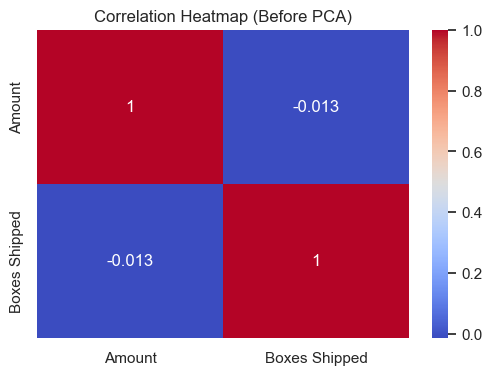

In [39]:
plt.figure(figsize=(6,4))
sns.heatmap(df_standardized[['Amount','Boxes Shipped']].corr(), 
            annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap (Before PCA)")
plt.show()

The correlation between the numerical features is very weak (≈ -0.013).

Since there is no strong linear relationship between the features,
PCA is not necessary in this case.

Therefore, dimensionality reduction is not applied.

The heatmap shows the correlation between the numerical features:

- The diagonal values are 1 because each feature is perfectly correlated with itself.
- The correlation between `Amount` and `Boxes Shipped` is approximately *-0.013*.

A correlation value close to 0 indicates that there is almost **NO linear** relationship between the two features.

This means that `Amount` and `Boxes Shipped` do not move together in a predictable linear pattern.

Since PCA is most useful when features are strongly correlated, 
the benefit of dimensionality reduction in this case may be limited.

Therefore, applying PCA here is mainly for demonstration purposes rather than necessity.

## 6. Data Reduction – Principal Component Analysis (PCA)

Principal Component Analysis (PCA) is a dimensionality reduction technique.

Instead of working directly with the original features, PCA creates new features called **principal components**.

These components:

- Are linear combinations of the original features
- Are uncorrelated with each other
- Capture variance in descending order (from most important to least)

The first principal component (PC1) captures the largest possible variance in the dataset.

The second principal component (PC2) captures the next largest variance, while being orthogonal (perpendicular) to PC1.

This allows us to reduce dimensionality while retaining most of the important information in the data.

### Visual Intuition

Imagine we have two features:

X1 = Amount  
X2 = Boxes Shipped  

If we plot the data points, they may look like this:

              X2
               |
               |
               |        *
               |      *
               |    *
               |  *
               | *
               |________________________ X1

Notice that the points follow a diagonal pattern.
This means the two features are correlated and contain overlapping information.

Instead of keeping both X1 and X2 separately,
PCA finds the direction where the data varies the most.

That direction becomes **Principal Component 1 (PC1)**.

              X2
               |
               |        *
               |      *
               |    *
               |  *
               | *
               |________________________ X1
                    \
                     \
                      \
                       \
                        → PC1 (maximum variance direction)

PC2 is the direction perpendicular to PC1.

If most of the variation is along PC1,
then PC1 alone captures most of the dataset’s information.

In that case, we can reduce:

2 features → 1 feature (PC1)

while keeping most of the variance.

In [40]:
from sklearn.decomposition import PCA

X = df_standardized[['Amount', 'Boxes Shipped']]

pca = PCA(n_components=2)
principal_components = pca.fit_transform(X)

print("Explained Variance Ratio:", pca.explained_variance_ratio_)

Explained Variance Ratio: [0.50657693 0.49342307]


The `Explained Variance Ratio` indicates how much of the total information (variance) is captured by each principal component.

For example:
- If PC1 explains 85% of the variance, it means that one new feature already summarizes most of the dataset's information.
- If PC1 and PC2 together explain nearly 100%, then very little information is lost.

When most of the variance is captured by fewer components, dimensionality reduction is considered effective.

This helps simplify models, reduce computational cost, and sometimes improve generalization performance.

In [39]:
# # In addition to the heatmap, we can visualize the relationship between two features using a scatter plot. 
# # A scatter plot allows us to observe whether the features exhibit a linear pattern, meaning whether they increase or decrease together in a consistent way.


# plt.figure(figsize=(6,4))
# plt.scatter(df_standardized['Amount'], df_standardized['Boxes Shipped'])
# plt.xlabel("Amount (Standardized)")
# plt.ylabel("Boxes Shipped (Standardized)")
# plt.title("Scatter Plot: Amount vs Boxes Shipped")
# plt.show()

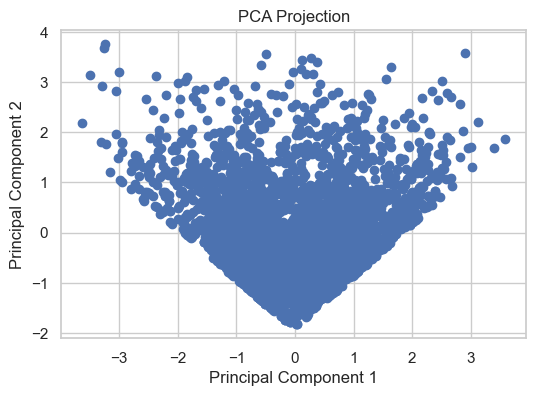

In [41]:
plt.figure(figsize=(6,4))
plt.scatter(principal_components[:,0], principal_components[:,1])
plt.title("PCA Projection")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

Each point in this plot represents one sales transaction.

The axes no longer represent the original features (`Amount` and `Boxes Shipped`).
Instead:

- The horizontal axis represents Principal Component 1 (PC1).
- The vertical axis represents Principal Component 2 (PC2).

PC1 captures the direction of maximum variance in the data.
PC2 captures the second most important direction, perpendicular to PC1.

The spread of points along the horizontal direction indicates how much variation is captured by PC1.
If most of the spread appears horizontally, it suggests that PC1 captures most of the dataset's information.

This projection allows us to visualize high-dimensional data in a lower-dimensional space.

# Assignment

In this assignment, you will:
- **Task 1**
Identify data quality issues in the dataset.

- **Task 2**
Apply one missing value strategy and explain why.

- **Task 3**
Detect and handle outliers using IQR.

- **Task 4**
Normalize numerical features using both Min-Max and Z-score.

- **Task 5**
Apply PCA only if the numerical features show a correlation.


End of lab 4.